# bigforecast

This notebook serves as the front-end for [bigforecast](https://github.com/jameslamb/bigforecast), a project completed as part of the Summer 2017 session of "W251: Scaling Up! Really Big Data", a course in UC-Berkeley's Master of Information in Data Science (MIDS) program.

The code blocks below allow you to play with a unique dataset we've created for macroeconomic research. Like traditional datasets in econ/finance, it includes time-series of globally-important macro variables like blue chip stock prices and the price of oil. However, we also have ingested (and are still ingesting!) a corpus of global news articles from the [GDELT Event Database](https://www.gdeltproject.org/). This will allow researchers to let their curiosity take them to new and exciting places...some unorthodox features that could be used to explain financial phenomena include:

* Count of articles-per-hour (globally) with the words "financial", "crisis", or "bailout" in the title
* Average tone/sentiment of Wall Street Journal articles over time
* Average tone/sentiment of non-US articles mentioning the United States Federal Reserve

## 1. Load Dependencies

Most of the code needed to interact with this system is available inside the `bigforecast` package. Anything else added below is specific to interactive work with the databases we've created.

In [1]:
import bigforecast.elasticsearch as bgfe
import bigforecast.influx as bgfi
import bigforecast.timeseries as bgfts

# Plotting
%matplotlib inline  

/root/bin/anaconda3/envs/bigforecast/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 2. Search for Data

There are two sources of data in this project: macro data stored in InfluxDB and news articles stored in Elasticsearch. In this section, we'll show how to hit these data sources to create a training dataset.

### a. InfluxDB

InfluxDB holds time-series data from [Yahoo Finance](). Field names in this DB correspond to financial tickers on Yahoo Finance. To get a list of tickers, you can use functions available in `bigforecast`:

In [2]:
# Connect to the DB
influxDB = bgfi.db_connect(host="modelbox",
                           database="modeldb",
                           client_type="dataframe")

# List available fields:
bgfi.list_series(db_client=influxDB)

Series available in this DB:


['AAPL',
 'AUDUSD',
 'BP',
 'CAD',
 'CVX',
 'EURGBP',
 'EURJPY',
 'EURRUB',
 'EURUSD',
 'GBPUSD',
 'GOOG',
 'LUKOY',
 'NZDUSD',
 'OJSCY',
 'PBR',
 'PTR',
 'RDS-A',
 'SHLX',
 'USDBRL',
 'USDCAD',
 'USDCHF',
 'USDJPY',
 'USDMXN',
 'USDRUB',
 'USO',
 'XOM']

Looks like the stock prices for British Petroleum ([BP](https://finance.yahoo.com/quote/BP?p=BP)), PetroChina ([PTR](https://finance.yahoo.com/quote/ptr?ltr=1)), and Rosneft ([OSJCY](https://finance.yahoo.com/quote/ojscy?ltr=1)) are available! Let's pull all three from InfluxDB and see how well we can predict Petrobras's share price.

In [3]:
# Get a windowed dataset
trainDF = bgfi.build_dataset(db_client=influxDB,
                             var_list=['BP', 'PTR', 'OJSCY'],
                             start_time='2016-08-01 00:00:00',
                             end_time='2017-08-22 00:00:00',
                             window_size='15m')

# Drop NAs in the resulting DataFrame
trainDF = trainDF.dropna(axis=0, how='any')

# Print the first few rows
print(trainDF.shape)
trainDF.head(5)

(36673, 3)


,PTR,BP,OJSCY
2016-08-01 00:00:00+00:00,68.113494,34.488214,4.490523
2016-08-01 00:15:00+00:00,68.113976,34.488206,4.490543
2016-08-01 00:30:00+00:00,68.114555,34.488197,4.490567
2016-08-01 00:45:00+00:00,68.115135,34.488188,4.490591
2016-08-01 01:00:00+00:00,68.115715,34.488179,4.490615


### b. Elasticsearch

[Elasticsearch](https://www.elastic.co/) is an distributed, document-based datastore built on top of a world-class open-source search engine called [Apache Lucene](https://lucene.apache.org/core/). In this project, we use Elasticsearch to give you access to the [GDELT Project](https://www.gdeltproject.org/data.html) global news article dataset. This dataset is freely available and you could even [download the CSV files of article links manually](http://data.gdeltproject.org/events/index.html), but a lot of work would still need to be done to create useful feature vectors from the data.

In this project, we've set up a pipeline for ingesting these articles, enriching them with some NLP features like tone and impact, and writing them into Elasticsearch. Now that the data have been indexed into Elasticsearch, you can create features like:

- Average sentiment (aggregated over 1-hour windows) of articles mentioning "US Federal Reserve"
- Count (aggregated over 15-minute windows) of articles with positive sentiment which mention at least two of "OPEC", "Rosneft", and "Petrobras"
- Average [Goldstein conflict/cooperation scale](http://web.pdx.edu/~kinsella/jgscale.html) (aggregated over 12-hour windows) of articles mentioning "environmental", "protestors", and "law"

In the code below, we use two functions from the `bigforecast` package to pull additional features from Elasticsearch.

In [4]:
query = {
  "_source": {
    "include": [
      "title",
      "AvgTone",
      "GoldsteinScale",
      "text"
    ]
  },
  "query": {
    "bool": {
      "filter": {
        "range": {
          "timestamp": {
            "gte": "2017-08-19T17:00:00",
            "lte": "now"
          }
        }
      },
      "should": {
        "term": {
          "title": "oil"
        }
      }
    }
  },
  "aggs": {
    "time": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "15m",
        "min_doc_count": 0
      }
    }
  },
  "size": 0
}

In [5]:
# Pull counts of oil docs
oil_doc_series = bgfe.doc_count(es_host="http://169.53.131.87:9200",
                                es_index="news",
                                query=query,
                                feature_name="oil_articles",
                                window_size="15m")
oil_doc_series.head()

time
2017-08-21 08:30:00    1258
2017-08-21 08:45:00    1878
2017-08-21 09:00:00       0
2017-08-21 09:15:00       0
2017-08-21 09:30:00       0
Name: oil_articles, dtype: int64

In [6]:
import pandas as pd
trainDF.index.tz = None
trainDF = trainDF.join(oil_doc_series)
trainDF.head()

,PTR,BP,OJSCY,oil_articles
2016-08-01 00:00:00,68.113494,34.488214,4.490523,NaN
2016-08-01 00:15:00,68.113976,34.488206,4.490543,NaN
2016-08-01 00:30:00,68.114555,34.488197,4.490567,NaN
2016-08-01 00:45:00,68.115135,34.488188,4.490591,NaN
2016-08-01 01:00:00,68.115715,34.488179,4.490615,NaN


## 3. Build a Model

### a. Model Parameters

In this section, we'll train a few time-series models to predict the variable of interest and compare their performance. To accomplish this, you need to specify a few parameters below.

- `TARGET` is a string identify the name of the variable you want to forecast.
- `X_VARS` is a list of strings identifying the explanatory variables you want to use.

In [7]:
# Set up model params

# Name of the variable you want to forecast
TARGET = 'PTR'

# (Optional) List of names of exogeneous variables
X_VARS = ['OJSCY', 'BP', 'oil_articles']

### b. Training

With these parameters set up, we can now train a time-series model! In the example below, we train an autoregressive integrated moving average ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)) model. ARIMA models and their [many variants](https://www.otexts.org/fpp/8) are trained to find a relationship between the current value of a time series and its past values. They may also depend (optionally) on exogenous regressors.

The main purpose of the `bigforecast` project is to provide modellers with a never-before-seen dataset for investigating macroeconomic and financial research questions. In keeping with this goal, we've abstracted away many of the modelling details and hard-coded reasonable defaults for various model training parameters. Our hope is that you will use this notebook to explore different **features** that can be created from the collections we've created in InfluxDB and Elasticsearch.

To train a model on the data pulled in previous sections, run the code below.

In [8]:
# Train a model
mod = bgfts.train_model(trainDF[TARGET], model_type="ARIMA")

# Examine model fit
mod.summary2()

# TODO: Evaluate out-of-sample accuracy

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARIMA
======================================================================
Model:              ARIMA            BIC:                 -163921.8900
Dependent Variable: D.PTR            Log-Likelihood:      81982.      
Date:               2017-08-21 18:21 Scale:               1.0000      
No. Observations:   36672            Method:              css-mle     
Df Model:           3                Sample:              08-01-2016  
Df Residuals:       36669                                 08-18-2017  
Converged:          1.0000           S.D. of innovations: 0.026       
AIC:                -163955.9291     HQIC:                -163945.111 
-----------------------------------------------------------------------
                  Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const            -0.0002    0.0000    -4.0465  0.0001  -0.0003  -0.0001
ar.L1.D.PTR      -0.1088    0.0069   -15.8611  0.0000  -0.1222  -0.0954
ma.L1.D.PTR      -0.6074    0.0048  -126.3464  0.0000  -0.6168  -0.5980
--------------------------------------------------------------------------------
                 Real            Imaginary           Modulus           Frequency
--------------------------------------------------------------------------------
AR.1           -9.1915              0.0000            9.1915              0.5000
MA.1            1.6463              0.0000            1.6463              0.0000
======================================================================

"""

## 4. Produce Forecasts

### a. Evaluate Forecasts

You can use the code below to evaluate your forecasts. If they don't look great, try pulling new data and re-running the pipeline. The magic feature combination exists out there! We believe in you.

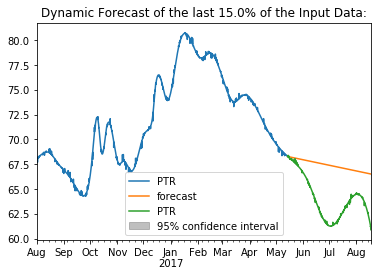

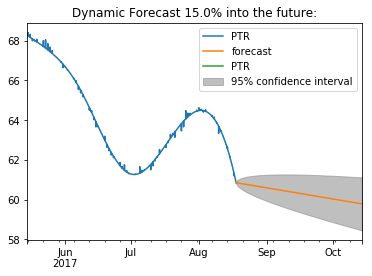

In [9]:
# Create prediction plots
bgfts.prediction_plots(mod, trainDF, TARGET)

## 5. References

See [the bigforecast repo](https://github.com/jameslamb/bigforecast/blob/dev/docs/references.md) for a full list of references.